In [ ]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sentiment_df = pd.read_csv('/content/sentiment_statisticscc1e57a.csv')
calls_df = pd.read_csv('/content/callsf0d4f5a.csv')
customers_df = pd.read_csv('/content/customers2afd6ea.csv')
call_reasons_df = pd.read_csv('/content/reason18315ff.csv')

In [ ]:
# Listing dataframes, to display basic information regarding each one of them
dfs = [calls_df, customers_df, call_reasons_df, sentiment_df]
df_names = ["calls_df","customers_df","call_reasons_df","sentiment_df"]

for i, df in enumerate(dfs):
    print(f"Dataframe {df_names[i]} info:")
    print(df.info())
    print("\n")

Dataframe calls_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   call_id                  71810 non-null  int64 
 1   customer_id              71810 non-null  int64 
 2   agent_id                 71810 non-null  int64 
 3   call_start_datetime      71810 non-null  object
 4   agent_assigned_datetime  71810 non-null  object
 5   call_end_datetime        71810 non-null  object
 6   call_transcript          71810 non-null  object
dtypes: int64(3), object(4)
memory usage: 3.8+ MB
None


Dataframe customers_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       71810 non-null  int64  
 1   customer_name     71810 non-null  object 
 2   eli

All dataframes contain valid entries i.e. no NULL values in call dataframes.

*  There are missing values in the elite_level_code column.
*  There are some missing values in agent_tone and average_sentiment.
*  Entries in call_reason df are less than calls df




In [ ]:
# to calculate handle and response times, we will convert the concerned columns in datetime datatype
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'])
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'])
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'])

# calculate the handle and speed to answer time
calls_df['handle_time'] = calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']
calls_df['speed_to_answer'] = calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']

# convert the time duration into seconds
calls_df['handle_time'] = calls_df['handle_time'].dt.total_seconds()/60
calls_df['speed_to_answer'] = calls_df['speed_to_answer'].dt.total_seconds()/60

In [ ]:
avg_handle_time = round(calls_df['handle_time'].mean(),2)
avg_speed_to_answer = round(calls_df['speed_to_answer'].mean(),2)

median_handle_time = calls_df['handle_time'].median()
median_speed_to_answer = calls_df['speed_to_answer'].median()

range_handle_time = calls_df['handle_time'].max() - calls_df['handle_time'].min()
range_speed_to_answer = calls_df['speed_to_answer'].max() - calls_df['speed_to_answer'].min()

print(avg_handle_time, avg_speed_to_answer, median_handle_time, median_speed_to_answer, range_handle_time, range_speed_to_answer)

11.62 7.28 7.0 7.0 119.0 12.0


This suggests that while the average handling time varies significantly, the speed to answer is more consistent but still with room for improvement.
We will label all the handle and speed to answer times to be long, if they are greater than average durations. Now, we need to find the factors contributing to higher durations for certain calls than others.

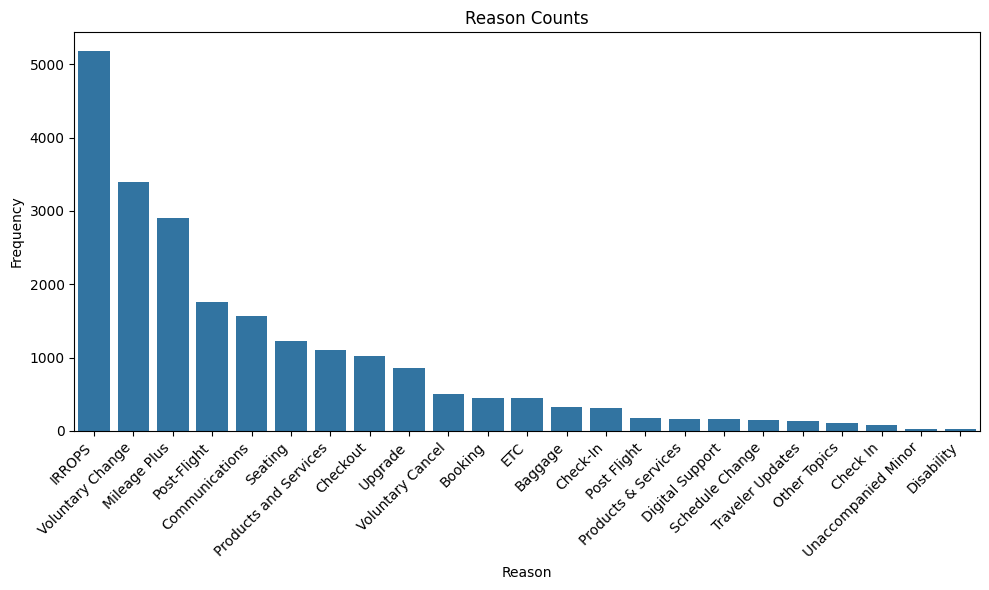

In [ ]:
# primary factor for high handle time is call reason, since certain reasons lead to longer calls
call_reasons_df['primary_call_reason'] = call_reasons_df['primary_call_reason'].str.replace(r'\s+', ' ', regex=True).str.strip()

# merging reason and calls df
call_reasons_df_merged = pd.merge(calls_df, call_reasons_df, on='call_id', how='inner')

# In case of handle time, call reason is primary factor, since it affects the time agent takes to solve the issue related to reason
# considering handle times greater than AHT to be long, lets find out the primary call reasons which lead to longer handle times
above_avg_duration = call_reasons_df_merged[call_reasons_df_merged['handle_time'] > avg_handle_time]
reasons_above_avg = above_avg_duration['primary_call_reason'].value_counts()

# Plotting the reasons with their count in longer handle time
plt.figure(figsize = (10,6))
sns.barplot(x=reasons_above_avg.index, y=reasons_above_avg.values)

plt.title('Reason Counts')
plt.xlabel('Reason')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Categories such as "Mileage Plus," "IRROPS," "Post-Flight," and "Voluntary Change" have the longest average handle times, with AHT ranging from approximately 13 to 22 minutes.

Call reasons like "Baggage," "Booking," "Digital Support," and "Traveler Updates" have significantly lower AHT values, generally between 5 to 9 minutes, hence they can somewhat be solved at IVR level to some extent.



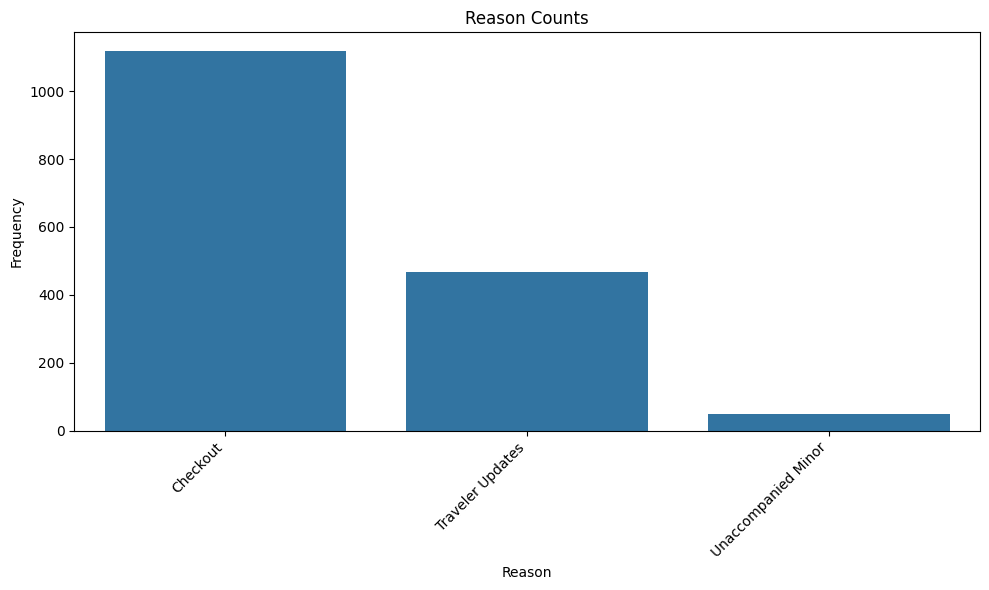

In [ ]:
# similarly for AST
above_avg_ast = call_reasons_df_merged[call_reasons_df_merged['speed_to_answer'] > avg_handle_time]
reasons_above_avg_ast = above_avg_ast['primary_call_reason'].value_counts()

# plotting the reasons wrt count
plt.figure(figsize = (10,6))
sns.barplot(x=reasons_above_avg_ast.index, y=reasons_above_avg_ast.values)

plt.title('Reason Counts')
plt.xlabel('Reason')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Due to a more uniform distribution of AST, most call reasons have a relatively consistent AST, with the majority being around 7 to 9 minutes.

However, certain reasons like "Checkout" and "Traveler Updates" have higher AST values, indicating potential bottlenecks in connecting customers to agents.



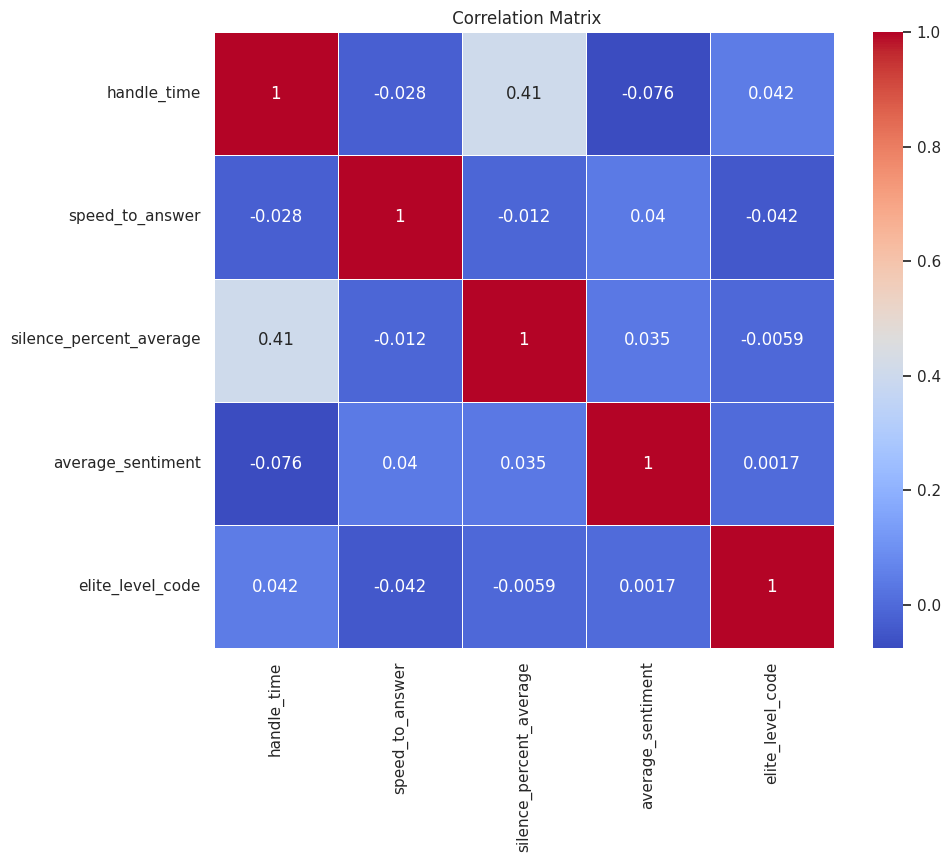

In [ ]:
# Now, due to longer AHT,AST the sentiment of customer as well as agent. So, lets find out the correlation between them

call_sentiment_merged = pd.merge(calls_df, sentiment_df,on='call_id',how='inner')
call_sentiment_merged = pd.merge(call_sentiment_merged, customers_df, on='customer_id',how='inner')

correlation_matrix = call_sentiment_merged[['handle_time','speed_to_answer', 'silence_percent_average', 'average_sentiment', 'elite_level_code']].corr()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title(" Correlation Matrix")
plt.show()


There is a weak negative correlation of -0.076 between AHT and average sentiment, suggesting that as sentiment becomes more negative, the handle time slightly increases.

The correlation between AST and average sentiment is positive but very weak at 0.039, indicating a minimal impact of customer sentiment on the speed of answer.


Key Insights:
* **Complex Issues Drive High AHT:** Call reasons that involve complex processes, like "Mileage Plus" and "Post-Flight," tend to have significantly longer handle times.
* **Opportunities for IVR Improvements:** More straightforward issues like "Baggage," "Booking," and "Digital Support" have shorter handle times, indicating potential areas where IVR enhancements could help reduce agent involvement.
* **Sentiment Impact is Limited:** The weak correlation between sentiment and both AHT and AST suggests that while sentiment affects the interaction, it's not the primary driver of extended durations.


In [ ]:
# We will analyze call transcripts and call types to identify specific recurring issues
# that could potentially be automated using the IVR system, thereby reducing the workload on agents.

from collections import Counter
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# get array of words in each sentence of the transcript and get their frequency

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return words

In [ ]:
calls_df['processed_transcript'] = calls_df['call_transcript'].apply(preprocess_text)
all_words = [word for sentence in calls_df['processed_transcript'] for word in sentence]
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

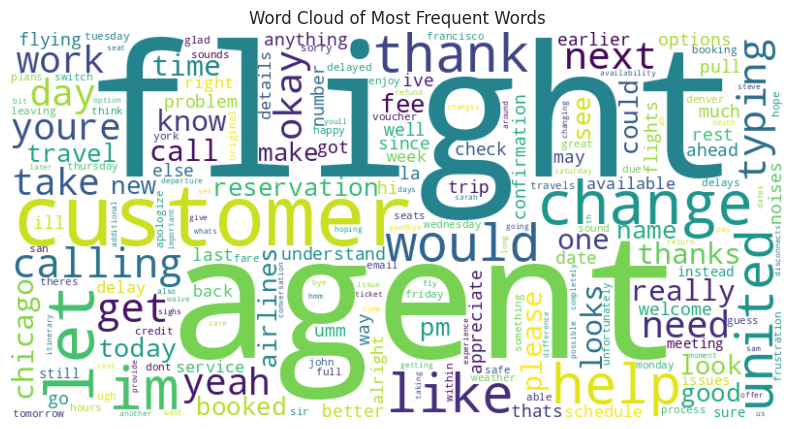

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

The most common words and phrases from the call transcripts reveal several recurring themes:

* **Frequently mentioned topics:** Words like "flight," "change," "reservation," "check," and "confirmation" suggest that many calls are related to flight details, booking changes, reservations, and checking information.

* **Agent Interactions:** High occurrences of words like "agent," "help," "united," and "customer" indicate the reliance on agents for support.

* **Problematic areas:** Terms such as "fee," "problem," and "understand" imply common issues or confusion that might lead to customer dissatisfaction or require clarification

Recommendations for IVR System Improvements:

**Automate Flight Information Requests:** Since "flight" and "reservation" appear frequently, updating the IVR to handle queries about flight status, reservation details, and changes could reduce agent involvement.

**Self-Service Options for Common Issues:** Implement options in the IVR for managing reservation changes, checking confirmations, and handling minor issues that relate to fees or booking adjustments.

**Improved Customer Guidance:** Introduce more explicit guidance on the IVR for self-solving common problems to reduce the sentiment of confusion or misunderstanding observed in the transcripts.


In [ ]:
# Now, analysing with help of each feature, to calculate durations during high volumes of calls in a given timeframe
merged_df = pd.merge(calls_df, customers_df, on='customer_id', how='left')
merged_df = pd.merge(merged_df, call_reasons_df, on='call_id', how='left')
merged_df = pd.merge(merged_df, sentiment_df, on='call_id', how='left')

In [ ]:
# Mapping tones to numeric values for better comparison

tone_mapping = {
    'polite': 1,
    'calm': 2,
    'neutral': 3,
    'angry': 4,
    'frustrated': 5
}

# Apply the mapping to the 'customer_tone' column
merged_df['customer_tone'] = merged_df['customer_tone'].map(tone_mapping)
merged_df['agent_tone'] = merged_df['agent_tone'].map(tone_mapping)

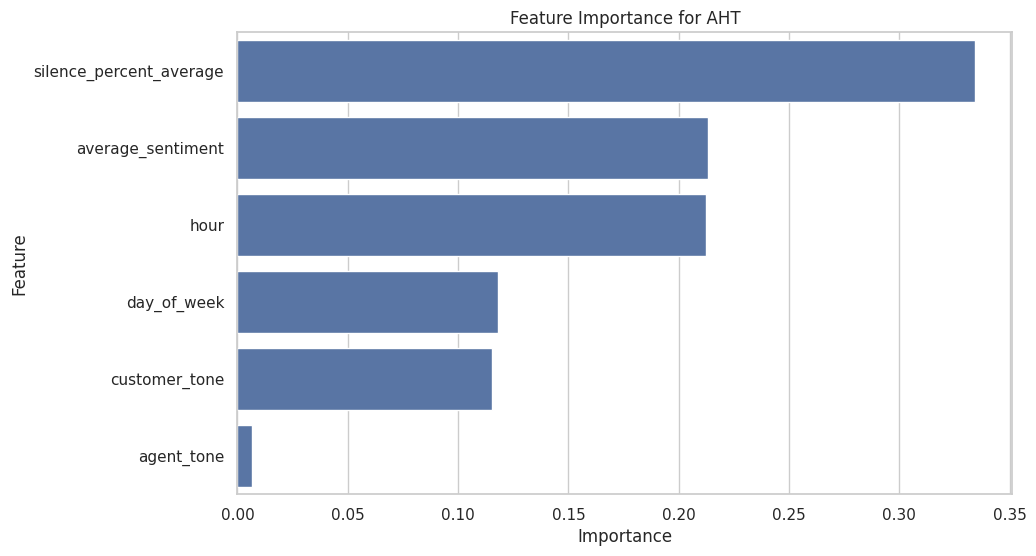

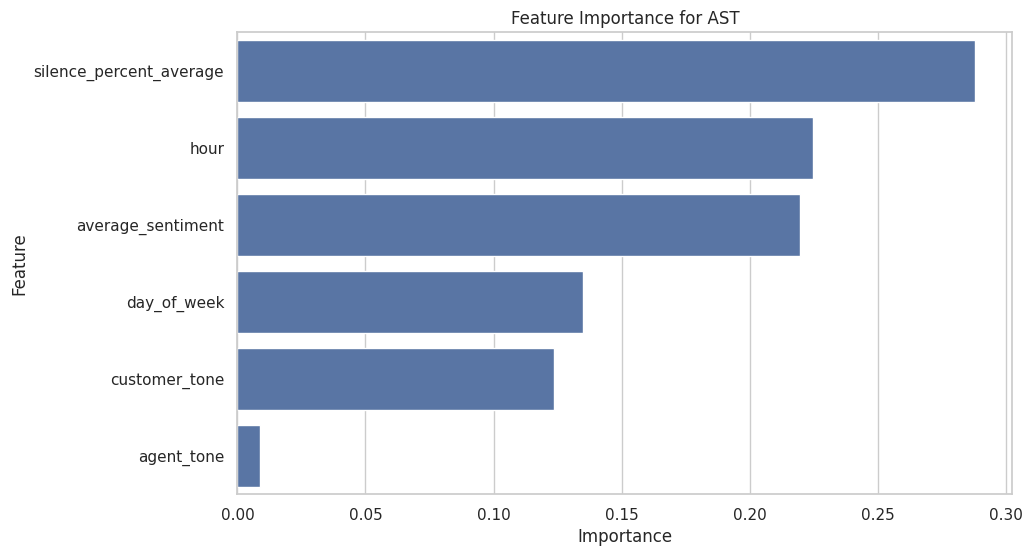

In [ ]:
# Calculating high call volume data with respect to each feature and handle time, speed to answer time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

merged_df['call_start_datetime'] = pd.to_datetime(merged_df['call_start_datetime'])


merged_df['hour'] = merged_df['call_start_datetime'].dt.hour
merged_df['day_of_week'] = merged_df['call_start_datetime'].dt.dayofweek

call_volume_by_hour = merged_df.groupby('hour').size()
high_volume_hours = call_volume_by_hour[call_volume_by_hour > call_volume_by_hour.mean()].index

# get the high volume hours data
high_volume_df = merged_df[merged_df['hour'].isin(high_volume_hours)]

# Finding effect of tone, sentiment and silence on time
merged_df['agent_tone'] = merged_df['agent_tone'].fillna(merged_df['agent_tone'].mean())
merged_df['customer_tone'] = merged_df['customer_tone'].fillna(merged_df['customer_tone'].mean())
merged_df['average_sentiment'] =merged_df['average_sentiment'].fillna(merged_df['average_sentiment'].mean())
merged_df['silence_percent_average'] = merged_df['silence_percent_average'].fillna(merged_df['silence_percent_average'].mean())

X = merged_df[['agent_tone', 'customer_tone', 'average_sentiment', 'silence_percent_average', 'hour', 'day_of_week']]
y_aht = merged_df['handle_time']
y_ast = merged_df['speed_to_answer']


X_train_aht, X_test_aht, y_train_aht, y_test_aht = train_test_split(X, y_aht, test_size=0.2, random_state=42)
X_train_ast, X_test_ast, y_train_ast, y_test_ast = train_test_split(X, y_ast, test_size=0.2, random_state=42)

rf_aht = RandomForestRegressor(random_state=42)
rf_aht.fit(X_train_aht, y_train_aht)


rf_ast = RandomForestRegressor(random_state=42)
rf_ast.fit(X_train_ast, y_train_ast)


aht_importances = rf_aht.feature_importances_
ast_importances = rf_ast.feature_importances_


aht_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': aht_importances}).sort_values(by='Importance', ascending=False)
ast_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': ast_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=aht_importance_df)
plt.title('Feature Importance for AHT')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=ast_importance_df)
plt.title('Feature Importance for AST')
plt.show()




*   In case of AST, silence is higher, since customer will be waiting for agent. Also, dependence on hour of the day (high volume on network), is important for AST and if higher AST, it affects the sentiment.
*   In case of AHT, silence is higher, since agent might be checking status of customer's query. However, high dependence of sentiment makes it evident that higher handle time negatively affects the sentiment, which was detected earlier using correlation matrix. Also, volume on network plays a crucial role.
* One good thing is that the agent tone remains uniform, suggesting we have a good workforce.



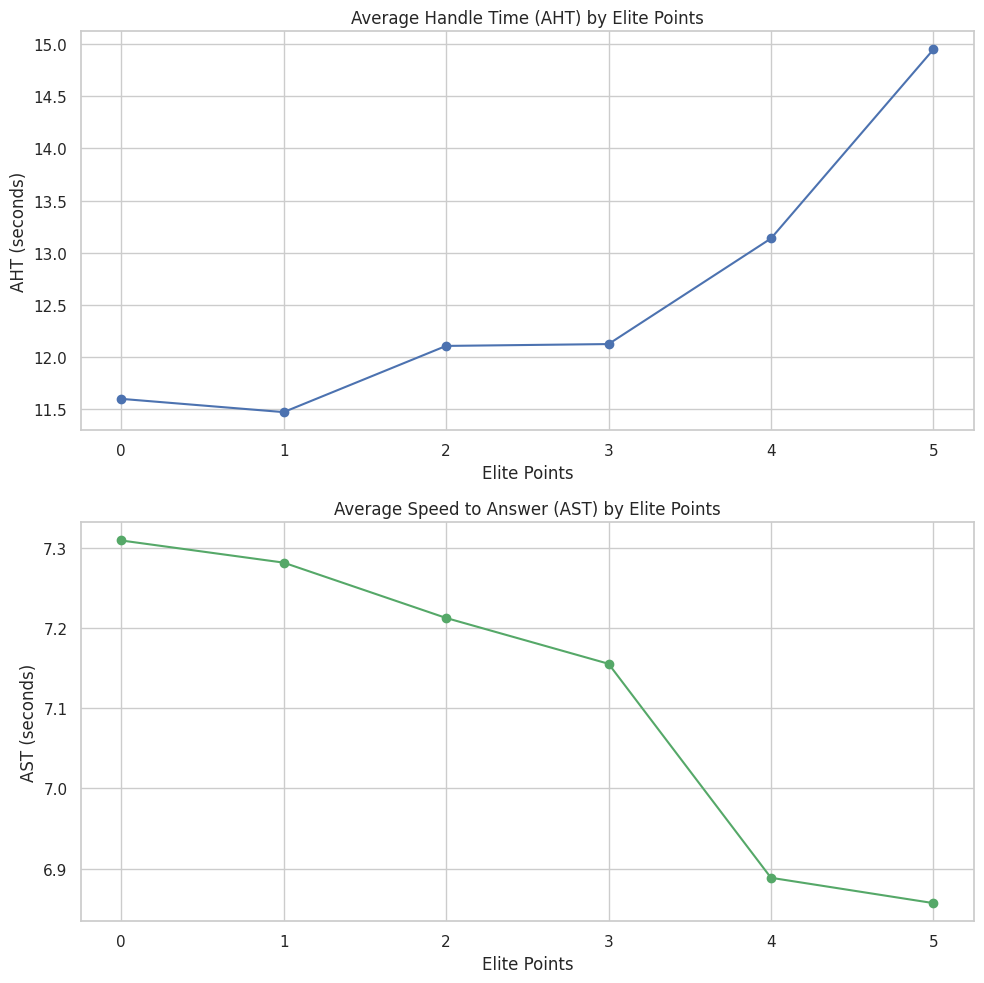

In [ ]:
# As a business, customer loyalty is prime factor for success, hence, we need to take care of customers based on their elite scores,
# i.e. they generate highest amount of profit for our airlines.

aht_ast_by_elite = merged_df.groupby('elite_level_code')[['handle_time', 'speed_to_answer']].mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plotting AHT
ax1.plot(aht_ast_by_elite.index, aht_ast_by_elite['handle_time'], label='AHT', marker='o', color='b')
ax1.set_title('Average Handle Time (AHT) by Elite Points')
ax1.set_xlabel('Elite Points')
ax1.set_ylabel('AHT (seconds)')
ax1.grid(True)


ax2.plot(aht_ast_by_elite.index, aht_ast_by_elite['speed_to_answer'], label='AST', marker='o', color='g')
ax2.set_title('Average Speed to Answer (AST) by Elite Points')
ax2.set_xlabel('Elite Points')
ax2.set_ylabel('AST (seconds)')
ax2.grid(True)

ax1.set_xticks(list(aht_ast_by_elite.index))
ax2.set_xticks(list(aht_ast_by_elite.index))

plt.tight_layout()
plt.show()

Above graph shows, that, the firm responds quickly to elite customers, i.e. quickly connects them to agent, and then depending on their query, the handle time may differ.

This is a great strategy to prioritize calls during high volume hours, however, a more weighted approach alongside some scheduling algorithm might be better, since we need to invest in customer loyalty, and having them wait for long durations, just to connect to the agent is not a good idea.

I would suggest we generates weights for each customer based on eliteness, then similar to some priority scheduler algorithm, we provide each customer a chance, this would allow the elite customers to enjoy their eliteness as well as provide others with a decent chance and reduced speed to answer time.